# Cài đặt các thư viện cần thiết

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10,6

#  Read file Web Trafic

In [59]:
raw_df = pd.read_csv('traffic.csv')
raw_df.head()

,Date,Visits
0,01-01-2020,1554.0
1,01-02-2020,2820.0
2,01-03-2020,2970.0
3,01-04-2020,2111.0
4,01-05-2020,2393.0


In [60]:
raw_df.tail()

,Date,Visits
1911,NaN,NaN
1912,NaN,NaN
1913,NaN,NaN
1914,NaN,NaN
1915,NaN,NaN


# Delete Mising Value and Outlier

In [61]:
raw_df['Date'].duplicated().sum()

1683

In [62]:
raw_df['Date'].isnull().sum()

1684

In [63]:
raw_df['Visits'].isnull().sum()

1684

In [64]:
notNull_df = raw_df.dropna()
notNull_df


,Date,Visits
0,01-01-2020,1554.0
1,01-02-2020,2820.0
2,01-03-2020,2970.0
3,01-04-2020,2111.0
4,01-05-2020,2393.0
...,...,...
227,8/15/2020,2221.0
228,8/16/2020,2724.0
229,8/17/2020,3456.0
230,8/18/2020,3581.0


In [65]:
notNull_df.shape

(232, 2)

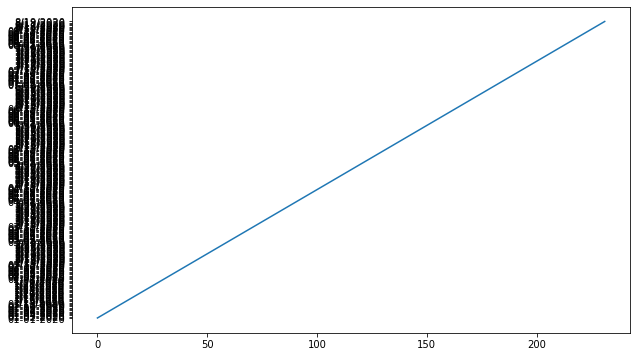

In [66]:
plt.plot(notNull_df['Date'])

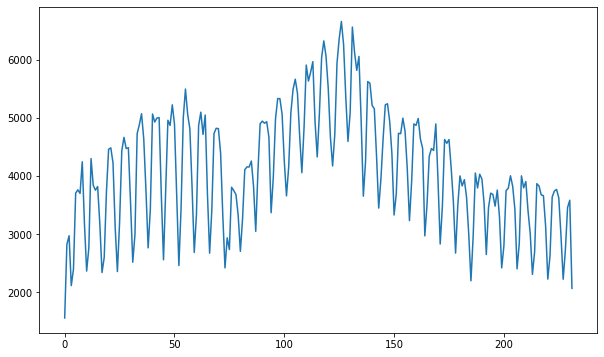

In [67]:
plt.plot(notNull_df['Visits'])

In [68]:
notNull_df['Date'] = pd.to_datetime(raw_df['Date'], infer_datetime_format=True)
indexed_df = notNull_df.set_index(['Date'])

In [69]:
from datetime import datetime
indexed_df.head()

,Visits
Date,
2020-01-01,1554.0
2020-01-02,2820.0
2020-01-03,2970.0
2020-01-04,2111.0
2020-01-05,2393.0


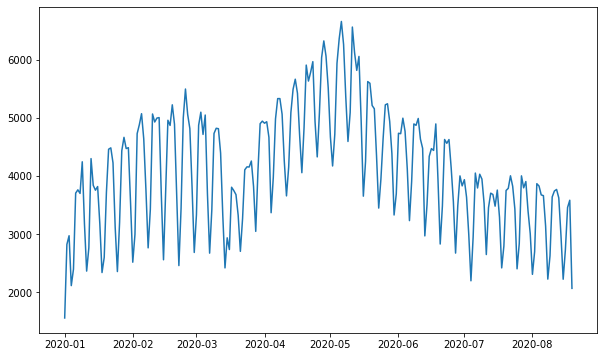

In [70]:
plt.plot(indexed_df)

# Normalization

,Visits
Date,
2020-08-15,2221.0
2020-08-16,2724.0
2020-08-17,3456.0
2020-08-18,3581.0
2020-08-19,2064.0


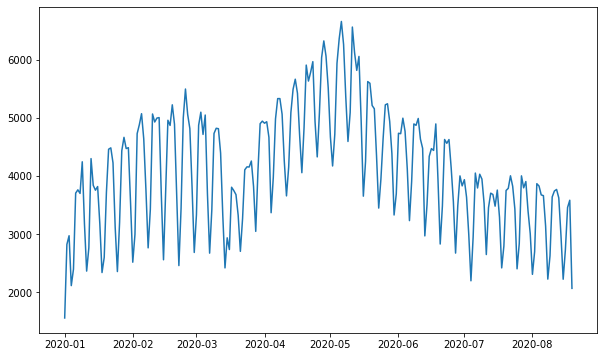

In [71]:
nor_df = indexed_df
plt.plot(nor_df)
nor_df.tail()

# Split into Train set and Test set

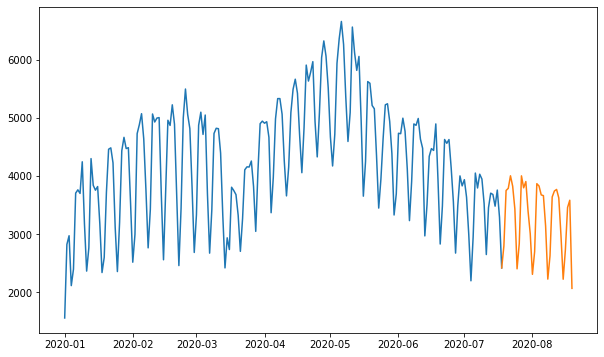

In [80]:
df_train = nor_df[:200].copy()
df_test = nor_df[199:].copy()
plt.plot(df_train)
plt.plot(df_test)

# Stationary

In [81]:
# Dickey Fuller Test

def perform_ad_fuller(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print("p-value: %f" % result[1])

perform_ad_fuller(df_train)

ADF Statistic: -1.412500
p-value: 0.576269


In [82]:
diff = df_train.diff(1).dropna()
perform_ad_fuller(diff)

ADF Statistic: -3.161396
p-value: 0.022331


# Chose Model

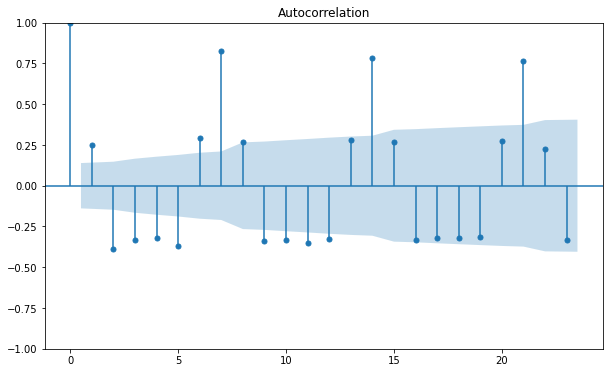

In [83]:
acf_plot = plot_acf(diff)

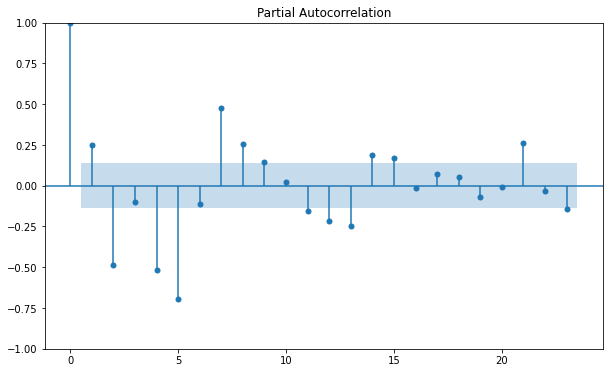

In [84]:
pacf_plot = plot_pacf(diff)

Dua tren PACF, nen bat dau voi AR voi lags 1,2,4,5,7

In [91]:
from statsmodels.tsa.arima.model import ARIMA

# 7,1,0 ARIMA Model

model = ARIMA(df_train, order=(7,1,0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Visits   No. Observations:                  200
Model:                 ARIMA(7, 1, 0)   Log Likelihood               -1445.712
Date:                Sun, 30 Apr 2023   AIC                           2907.424
Time:                        14:35:08   BIC                           2933.771
Sample:                    01-01-2020   HQIC                          2918.087
                         - 07-18-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1335      0.054     -2.492      0.013      -0.238      -0.028
ar.L2         -0.3882      0.058     -6.689      0.000      -0.502      -0.274
ar.L3         -0.2683      0.063     -4.273      0.0

In [78]:
import pmdarima as pm

model = pm.auto_arima(df_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3697.654, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3685.230, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3656.520, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3695.658, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3655.918, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3565.566, Time=0.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3624.881, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3566.859, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3517.436, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3596.297, Time=0.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3508.707, Time=0.34 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3578.939, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3511.232, Time=0.34 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : 

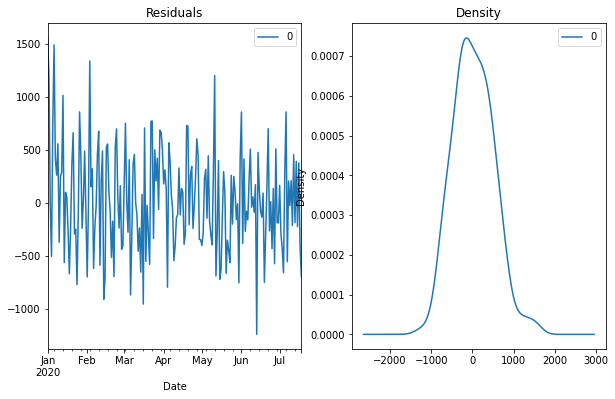

2020-07-18    3111.960138
2020-07-19    2523.799968
2020-07-20    2811.303668
2020-07-21    3157.627213
2020-07-22    3453.925588
2020-07-23    3934.684759
2020-07-24    3618.749095
2020-07-25    3166.935993
2020-07-26    3125.600858
2020-07-27    3121.819220
2020-07-28    3121.473249
2020-07-29    3121.441597
2020-07-30    3121.438701
2020-07-31    3121.438436
2020-08-01    3121.438412
2020-08-02    3121.438409
2020-08-03    3121.438409
2020-08-04    3121.438409
2020-08-05    3121.438409
2020-08-06    3121.438409
2020-08-07    3121.438409
2020-08-08    3121.438409
2020-08-09    3121.438409
2020-08-10    3121.438409
2020-08-11    3121.438409
2020-08-12    3121.438409
2020-08-13    3121.438409
2020-08-14    3121.438409
2020-08-15    3121.438409
2020-08-16    3121.438409
2020-08-17    3121.438409
2020-08-18    3121.438409
2020-08-19    3121.438409
Freq: D, Name: predicted_mean, dtype: float64

In [87]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

predictions = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
predictions

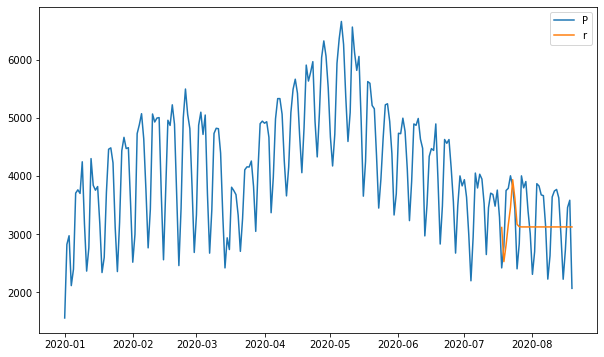

In [88]:
plt.plot(nor_df)
plt.plot(predictions)
plt.legend("Actual")
plt.legend("Predict")
plt.show()

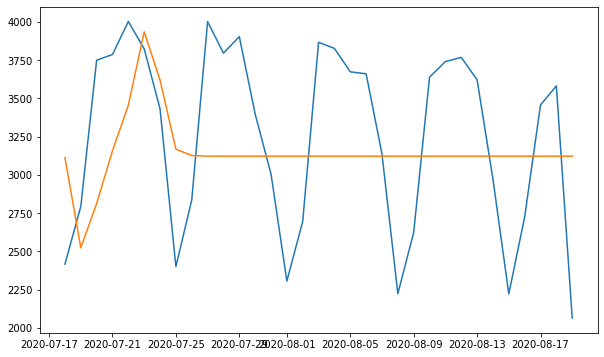

In [89]:
plt.plot(df_test)
plt.plot(predictions)

In [90]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
mse = mean_squared_error(df_test,predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_test,predictions)
mape = mean_absolute_percentage_error(df_test,predictions)
print("MSE :{}\
      RMSE :{}\
      MAE :{}\
      MAPE :{}".format(mse,rmse,mae,mape))


MSE :365936.7803224775      RMSE :604.927086781934      MAE :543.5219651431072      MAPE :0.17885309560516416
